### Train classification model

In [1]:
import os, sys
import scipy.misc
from glob import glob
import numpy as np
import random 
import shutil 
import keras
import time
import matplotlib.pyplot as plt
from keras.layers import Dense, Input, Conv2D, Flatten, MaxPool2D, Activation,Dropout, GlobalAveragePooling2D
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from keras import backend as K
from keras.models import Sequential
from keras.applications.vgg16 import VGG16
from keras.applications.resnet import ResNet50
from keras.applications.densenet import DenseNet121
from keras.models import load_model
from keras.optimizers import Adam
from keras import optimizers
import pickle

ROOT_DIR = os.path.abspath("../")

sys.path.append(ROOT_DIR)
import helpers

data_name = "cxr_normalvg1" 
DATASET_PATH = os.path.join(ROOT_DIR, "dataset", data_name ,"train")
TEST_DATASET_PATH = os.path.join(ROOT_DIR, "dataset", data_name ,"test")
EXPERIMENT_NAME = data_name #"cxr_normalvcovid+g1g2_new"

if not os.path.exists(os.path.join(ROOT_DIR, "models")):
    os.mkdir(os.path.join(ROOT_DIR, "models"))

LOG_PATH = os.path.join(ROOT_DIR, "models", EXPERIMENT_NAME)

if not os.path.exists(LOG_PATH):
    os.mkdir(LOG_PATH)

Using TensorFlow backend.
/home/hasib/anaconda3/envs/malaria/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/hasib/anaconda3/envs/malaria/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/hasib/anaconda3/envs/malaria/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/hasib/anaconda

In [2]:
# Helpers
def save_obj(obj, name):
    with open('{}'.format(LOG_PATH) + "/"+ name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name):
    with open('{}'.format(LOG_PATH) + name + '.pkl', 'rb') as f:
        return pickle.load(f)


def resnet50():
    base_model = ResNet50(weights='imagenet',include_top=False,pooling='avg',input_shape=(256, 256, 3))
    # Add FC layer
    predictions = Dense(2, activation='softmax', trainable=True)(base_model.output) 
    
    for layer in base_model.layers:
        layer.trainable=True
        
    model = Model(inputs=[base_model.input], outputs=[predictions])
        
    # Optimzer and loss
    optim = optimizers.Adadelta(lr=0.001) #Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
    loss_func = 'binary_crossentropy' 
    
    model.compile(optimizer=optim, loss=loss_func, metrics=['accuracy'])
    return model


def densenet121():
    base_model = DenseNet121(weights='imagenet',include_top=False,pooling='avg',input_shape=(256, 256, 3))
    # Add FC layer
    predictions = Dense(2, activation='softmax', trainable=True)(base_model.output) 
    
    for layer in base_model.layers:
        layer.trainable=True
        
    model = Model(inputs=[base_model.input], outputs=[predictions])
        
    # Optimzer and loss
    optim = optimizers.Adadelta(lr=0.001) #Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
    loss_func = 'binary_crossentropy' 
    
    model.compile(optimizer=optim, loss=loss_func, metrics=['accuracy'])
    return model



def vgg():
    base_model = VGG16(weights='imagenet',include_top=False,pooling='avg',input_shape=(256, 256, 3))
    # Add FC layer
    predictions = Dense(2, activation='softmax', trainable=True)(base_model.output) 
    
    for layer in base_model.layers:
        layer.trainable=True
        
    model = Model(inputs=[base_model.input], outputs=[predictions])
        
    # Optimzer and loss
    optim = optimizers.Adadelta(lr=0.001) #Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
    loss_func = 'binary_crossentropy' 
    
    model.compile(optimizer=optim, loss=loss_func, metrics=['accuracy'])
    return model


model = None
model = densenet121()
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 128, 128, 64) 9408        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1/conv[0][0]                 
____________________

In [3]:
# Define callbacks for learning rate scheduling, logging and best checkpoints saving
callbacks = [
    keras.callbacks.ModelCheckpoint('{}/{}.h5'.format(LOG_PATH, EXPERIMENT_NAME), monitor='val_loss', save_best_only=True, mode='min'),
    keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, verbose=1, patience=5, mode='min'), ## new_lr = lr * factor # 5
    keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, verbose=1, patience=15, mode='min', restore_best_weights=True), # 8
    keras.callbacks.CSVLogger('{}/training.csv'.format(LOG_PATH))
]

In [4]:
import tensorflow as tf
import keras_preprocessing
from keras_preprocessing import image
from keras_preprocessing.image import ImageDataGenerator


#---------------------------
# cxr
# 0 - cov
# 1 - normal
# 2 - pneu
#---------------------------
# cxr_normalvcovid
# 0 - cov19
# 1 - normal
#---------------------------
# cxr_pneucovid
# 0 - cov19
# 1 - pneu
#---------------------------
#class_weight = {0: 0.9, 1: 0.1}

def processing_func(img):
    # do sth
    
    
    return img


# preprocessing_function=None

TRAINING_DIR = DATASET_PATH
training_datagen = ImageDataGenerator(
        rescale = 1./255)
        #rotation_range=40,
        #width_shift_range=0.2,
        #height_shift_range=0.2,
        #shear_range=0.2,
        #zoom_range=0.2,
        #horizontal_flip=True,
        #fill_mode='nearest')

VALIDATION_DIR = TEST_DATASET_PATH
validation_datagen = ImageDataGenerator(rescale = 1./255)

train_generator = training_datagen.flow_from_directory(
    TRAINING_DIR,
    target_size=(256,256),
    class_mode='categorical',
    batch_size = 16
)

validation_generator = validation_datagen.flow_from_directory(
    VALIDATION_DIR,
    target_size=(256,256),
    class_mode='categorical',
    batch_size = 16
)

Found 33074 images belonging to 2 classes.
Found 4181 images belonging to 2 classes.


In [5]:
x, y = next(iter(train_generator))
x.shape, y.shape

((16, 256, 256, 3), (16, 2))

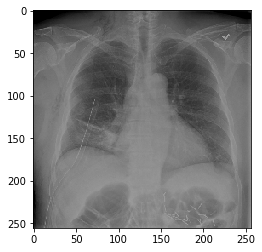

In [6]:
plt.imshow(x[0])

In [7]:
y[:5]

array([[0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.]], dtype=float32)

In [8]:
start_time = time.time()


history = model.fit_generator(train_generator, 
                    epochs=200, validation_data = validation_generator, 
                    verbose = 1,
                    class_weight=None,
                    callbacks=callbacks, shuffle=True)


end_time = time.time()
print("--- Time taken to train : %s hours ---" % ((end_time - start_time)//3600))

Instructions for updating:
Use tf.cast instead.
Epoch 1/200
2068/2068 [==============================] - 306s 148ms/step - loss: 0.0888 - accuracy: 0.9701 - val_loss: 3.3691e-04 - val_accuracy: 0.9900
Epoch 2/200
2068/2068 [==============================] - 290s 140ms/step - loss: 0.0072 - accuracy: 0.9995 - val_loss: 0.0014 - val_accuracy: 0.9900
Epoch 3/200
2068/2068 [==============================] - 290s 140ms/step - loss: 0.0044 - accuracy: 0.9996 - val_loss: 3.6319e-05 - val_accuracy: 0.9900
Epoch 4/200
2068/2068 [==============================] - 290s 140ms/step - loss: 0.0039 - accuracy: 0.9994 - val_loss: 5.4712e-05 - val_accuracy: 0.9900
Epoch 5/200
2068/2068 [==============================] - 290s 140ms/step - loss: 0.0028 - accuracy: 0.9998 - val_loss: 6.7703e-05 - val_accuracy: 0.9900
Epoch 6/200
2068/2068 [==============================] - 290s 140ms/step - loss: 0.0019 - accuracy: 0.9997 - val_loss: 1.9523e-05 - val_accuracy: 0.9900
Epoch 7/200
2068/2068 [===============

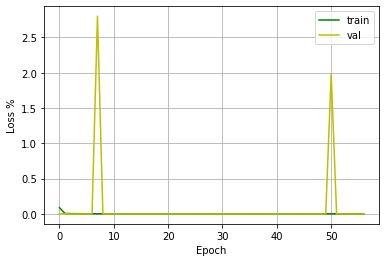

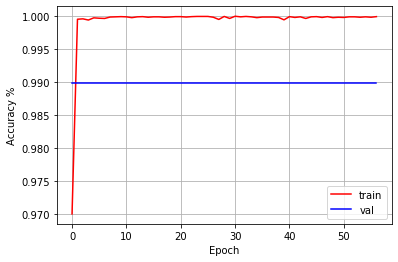

Done training and logging!


In [9]:
# Plot and save accuravy loss graphs individually
def plot_loss_accu(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(loss))
    plt.plot(epochs, loss, 'g')
    plt.plot(epochs, val_loss, 'y')
    #plt.title('Training and validation loss')
    plt.ylabel('Loss %')
    plt.xlabel('Epoch')
    plt.legend(['train', 'val'], loc='upper right')
    plt.grid(True)
    plt.savefig('{}/{}_loss.jpg'.format(LOG_PATH, EXPERIMENT_NAME), dpi=100)
    plt.show()
    
    loss = history.history['accuracy']
    val_loss = history.history['val_accuracy']
    epochs = range(len(loss))
    plt.plot(epochs, loss, 'r')
    plt.plot(epochs, val_loss, 'b')
    #plt.title('Training and validation accuracy')
    plt.ylabel('Accuracy %')
    plt.xlabel('Epoch')
    plt.legend(['train', 'val'], loc='lower right')
    plt.grid(True)
    plt.savefig('{}/{}_acc.jpg'.format(LOG_PATH, EXPERIMENT_NAME), dpi=100)
    plt.show()

plot_loss_accu(history)
print("Done training and logging!")

In [10]:
from keras.models import load_model

model = None
model = load_model("{}/{}.h5".format(LOG_PATH, EXPERIMENT_NAME), compile = False)
#model.summary()

In [11]:
# Get test data

#---------------------------
# cxr
# 0 - cov
# 1 - normal
# 2 - pneu
# test_all
#---------------------------
# cxr_normalvcovid
# 0 - cov19
# 1 - normal
#test_nvc
#---------------------------
# cxr_pneucovid
# 0 - cov19
# 1 - pneu
# test_pvc
#---------------------------


dest_path = os.path.join(ROOT_DIR, "dataset/numpy/")

x_test = np.load("{}/test_nvc.npy".format(dest_path))
y_test = np.load("{}/test_nvc_labels.npy".format(dest_path))
x_test.shape, y_test.shape

((4181, 256, 256, 3), (4181, 2))

In [12]:
# Standardize
x_test = x_test.astype('float32')
x_test /= 255

In [13]:
# Make predictions using trained model
y_pred = model.predict(x_test, verbose=1)
print("Predictions: ", y_pred.shape)


y_pred_inv = []

for y in y_pred:
    y = np.flip(y, 0 )
    y_pred_inv.append(y)

y_pred = np.array(y_pred_inv)
print("New: ", y_pred.shape)


# GTs
#y_test_flat = y_test

#y_pred_flat = []
#for pred in y_pred:
#    if pred > 0.5:
#        y_pred_flat.append(1)
#    else:
#        y_pred_flat.append(0)
#y_pred_flat = np.array(y_pred_flat)


# Convert ground truth to column values
y_test_flat = np.argmax(y_test, axis=1)
print("After flattening ground truth: ", y_test_flat.shape)


# Get labels from predictions
y_pred_flat = np.array([np.argmax(pred) for pred in y_pred]) 
print("Binarize probability values: ", y_pred_flat.shape)

assert y_pred_flat.shape == y_test_flat.shape, "Shape mismatch!"

4181/4181 [==============================] - 12s 3ms/step
Predictions:  (4181, 2)
New:  (4181, 2)
After flattening ground truth:  (4181,)
Binarize probability values:  (4181,)


In [14]:
# Sanity check

print(y_test.shape, y_test_flat.shape, y_pred.shape, y_pred_flat.shape)

(4181, 2) (4181,) (4181, 2) (4181,)


In [15]:
y_test_flat_ = []

for y in y_test_flat:
    if y==0:
        y_test_flat_.append(1)
    else:
        y_test_flat_.append(0)
        
        
#y_pred_flat_ = []

#for y in y_pred_flat:
#    if y==0:
#        y_pred_flat_.append(1)
#    else:
#        y_pred_flat_.append(0)
        
        
y_test_flat = np.array(y_test_flat_)
#y_pred_flat = np.array(y_pred_flat_)

print(y_test_flat.shape, y_pred_flat.shape)

y_test = keras.utils.to_categorical(y_test_flat, 2)
#y_pred = keras.utils.to_categorical(y_pred_flat, 2)
print(y_test.shape, y_pred.shape)

(4181,) (4181,)
(4181, 2) (4181, 2)


In [16]:
vals = []

for yhat, y in zip(y_pred_inv, y_test):
    if y[1] == 1:
        vals.append(yhat[1])
    
vals = np.array(vals)
vals.shape

(46,)

In [17]:
vals[:10]

array([0.00288511, 0.0138529 , 0.01928083, 0.00211627, 0.00095294,
       0.01106923, 0.00118169, 0.0648666 , 0.00271029, 0.0041646 ],
      dtype=float32)

In [18]:
y = [i for i in range(46)]

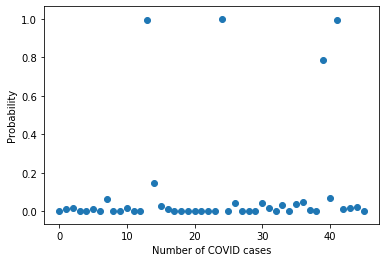

In [19]:
#plt.hist(vals, bins=46, color='c')
x = vals
plt.scatter(y, x)
#plt.title("Confidence of COVID-19 on NVC + G2 + G1")
plt.xlabel("Number of COVID cases")
#plt.grid(True)
plt.ylabel("Probability")
plt.savefig("{}/{}.pdf".format(LOG_PATH, EXPERIMENT_NAME), dpi=100)
plt.show()

In [20]:
np.count_nonzero(y_test_flat == 1)

46

In [21]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt

# Accuracy
acc = accuracy_score(y_test_flat, y_pred_flat) * 100
print("Accuracy :", acc)

Accuracy : 98.99545563262377


In [22]:
# Classification report

confusion_mtx = confusion_matrix(y_test_flat, y_pred_flat) 
print(confusion_mtx)
target_names = ['0', '1']
print(classification_report(y_test_flat, y_pred_flat, target_names=target_names))

[[4135    0]
 [  42    4]]
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      4135
           1       1.00      0.09      0.16        46

    accuracy                           0.99      4181
   macro avg       0.99      0.54      0.58      4181
weighted avg       0.99      0.99      0.99      4181



In [23]:
tn, fp, fn, tp = confusion_matrix(y_test_flat, y_pred_flat).ravel()
tn, fp, fn, tp

(4135, 0, 42, 4)

In [24]:
sensitivity = tp /(tp + fn)
sensitivity * 100

8.695652173913043

In [25]:
tp+fn

46

In [26]:
# Kappa
from sklearn.metrics import cohen_kappa_score

kp = cohen_kappa_score(y_test_flat, y_pred_flat)
print("Kappa :", kp)

Kappa : 0.15851870309849447


In [27]:
from sklearn.metrics import brier_score_loss

br = brier_score_loss(y_test_flat, y_pred_flat, pos_label=1)
print("Brier loss :", br)

Brier loss : 0.010045443673762257


In [28]:
# 0.0088
# 

In [29]:
# Average precision

from sklearn.metrics import average_precision_score
ap = average_precision_score(y_test, y_pred) * 100
print("Average precision :", ap)

# 75.81,

Average precision : 56.16808720075681


In [30]:
# Sensitivity and Specificity

#cm = confusion_matrix(y_pred=y_pred_flat, y_true=y_test_flat)
#total=sum(sum(cm))

##sensitivity = cm[0,0]/(cm[0,0]+cm[1,0])
#print('Sensitivity : ', sensitivity*100 )

#Specificity = cm[1,1]/(cm[1,1]+cm[0,1])
#print('Specificity : ', Specificity*100 )

In [31]:
from sklearn.metrics import roc_auc_score
print('Area under ROC curve : ', roc_auc_score(y_test, y_pred) *100 )

Area under ROC curve :  59.99474265285737


In [32]:
from sklearn.metrics import f1_score
F1_score = f1_score(y_test_flat, y_pred_flat, labels=None, average='binary', sample_weight=None)
F1_score * 100

16.0

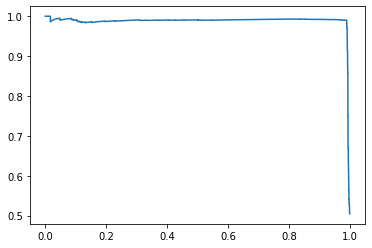

In [33]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve

# PR curve
y_true = y_test.ravel() 
y_preds = y_pred.ravel() 
precision, recall, thresholds = precision_recall_curve(y_true, y_preds)
plt.figure(20)
plt.plot(recall,precision)

In [34]:
ascore = {}
ascore["recall"] = recall
ascore["precision"] = precision
save_obj(ascore, "{}_PR_curve".format(data_name))

Area under the ROC curve for positive class: 0.5999526838757163


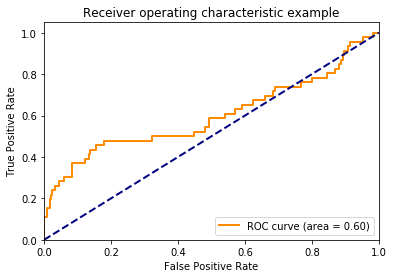

In [35]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp


# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])


# Compute micro-average ROC curve and ROC area
cls = 1 # class name
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

#print(roc_auc)
print("Area under the ROC curve for positive class:", roc_auc[1])


plt.figure()
lw = 2 # line width
plt.plot(fpr[cls], tpr[cls], color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[cls])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

# Save AUCROC for plotting
ascore = {}
ascore["fpr"] = fpr[cls]
ascore["tpr"] = tpr[cls]
ascore["roc_auc"] = roc_auc[cls]
save_obj(ascore, data_name)